### All data but clean

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [89]:
df = pd.read_csv('data/raw_dataset.csv')
df.shape

(4424, 35)

In [90]:
df = df[df["Target"].isin(["Dropout", "Graduate"])].copy()
print("Shape after keeping Dropout/Graduate:", df.shape)

Shape after keeping Dropout/Graduate: (3630, 35)


### Fix Previous qualification duplicate categories

In [91]:
prev_col = "Previous qualification"

prev_map = {
    15: 3,
    17: 4,
    8: 7,
    9: 7,
    10: 7,
    11: 7,
}

df[prev_col] = df[prev_col].replace(prev_map)

print("Previous qualification value counts after merge:")
print(df[prev_col].value_counts().sort_index())

Previous qualification value counts after merge:
Previous qualification
1     3019
2       22
3      156
4       13
5        1
6       15
7       57
12     149
13       6
14     164
16      28
Name: count, dtype: int64


### Group Mother's qualification and Father's qualification into 8 groups

In [92]:
m_f_qual_cols = ["Mother's qualification", "Father's qualification"]

qual_groups = [
    [1, 7, 8, 10, 11, 12, 14, 15, 17, 19, 20],         # group 1
    [25, 26],                                          # group 2
    [9, 18, 21, 27, 28],                               # group 3
    [6, 13, 16, 22, 23, 29, 31, 32],                   # group 4
    [2, 3, 30],                                        # group 5
    [4, 33],                                           # group 6
    [5, 34],                                           # group 7
    [24],                                              # group 8
]

def build_group_map(groups):
    mapping = {}
    for i, group in enumerate(groups, start=1):
        for code in group:
            mapping[code] = i   # map all codes in that list to group i
    return mapping

qual_map = build_group_map(qual_groups)

for col in m_f_qual_cols:
    df[col] = df[col].replace(qual_map)

print("\nMother's qualification value counts after grouping:")
print(df["Mother's qualification"].value_counts().sort_index())
print("\nFather's qualification value counts after grouping:")
print(df["Father's qualification"].value_counts().sort_index())


Mother's qualification value counts after grouping:
Mother's qualification
1    1053
2      14
3      16
4    2094
5     397
6      34
7      16
8       6
Name: count, dtype: int64

Father's qualification value counts after grouping:
Father's qualification
1    1569
2      10
3    1600
4      24
5     268
6      34
7      16
8     109
Name: count, dtype: int64


### Keep only Portuguese students (Nationality == 1)

In [93]:
nat_col = "Nacionality"
df = df[df[nat_col] == 1].copy()

print("\nShape after keeping only Nationality == 1 (Portugal):", df.shape)
print("Nationality value counts:")
print(df[nat_col].value_counts())


Shape after keeping only Nationality == 1 (Portugal): (3544, 35)
Nationality value counts:
Nacionality
1    3544
Name: count, dtype: int64


### Group Mother's occupation and Father's occupation into 8 groups

In [94]:
m_f_occ_cols = ["Mother's occupation", "Father's occupation"]

occ_groups = [
    [2, 17, 18, 14, 15, 16],                           # group 1
    [3, 19, 20, 21, 22],                               # group 2
    [4, 23, 24, 25, 26],                               # group 3
    [5, 27, 28, 29],                                   # group 4
    [6, 30, 31, 32, 33],                               # group 5
    [7, 34, 35, 43],                                   # group 6
    [8, 36, 37, 38, 39, 40, 41, 42, 44],               # group 7
    [1, 10, 11, 12, 13, 45, 46],                       # group 8
]

occ_map = build_group_map(occ_groups)

for col in m_f_occ_cols:
    df[col] = df[col].replace(occ_map)

print("\nMother's occupation value counts after grouping:")
print(df["Mother's occupation"].value_counts().sort_index())
print("\nFather's occupation value counts after grouping:")
print(df["Father's occupation"].value_counts().sort_index())


Mother's occupation value counts after grouping:
Mother's occupation
1      92
2     241
3     270
4     677
5     440
6      74
7     223
8    1498
9      29
Name: count, dtype: int64

Father's occupation value counts after grouping:
Father's occupation
1     115
2     149
3     317
4     313
5     406
6     191
7     563
8    1234
9     256
Name: count, dtype: int64


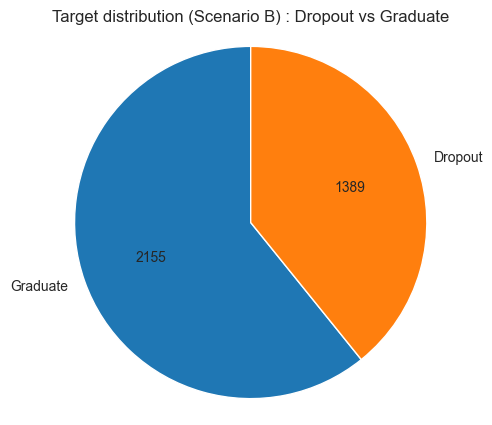

In [95]:
import matplotlib.pyplot as plt

counts = df["Target"].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    counts.values,
    labels=counts.index,
    startangle=90,
    autopct=lambda p: f"{int(round(p/100 * counts.sum()))}"
)
plt.title("Target distribution (Scenario B) : Dropout vs Graduate")
plt.axis("equal")
plt.show()

### Remove Nal first year

In [96]:
first_year_cols = [
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)"
]
df[first_year_cols] = df[first_year_cols].apply(pd.to_numeric, errors="coerce")
mask_all_zero = (df[first_year_cols] == 0).all(axis=1)

df = df[~mask_all_zero].copy()

print("Shape after removing NAL observations:", df.shape)
print("Removed rows:", mask_all_zero.sum())

Shape after removing NAL observations: (3398, 35)
Removed rows: 146


### Now we have cleand data

In [97]:
print("Cleaned data shape:", df.shape)
print("Target distribution:\n", df["Target"].value_counts())


Cleaned data shape: (3398, 35)
Target distribution:
 Target
Graduate    2082
Dropout     1316
Name: count, dtype: int64


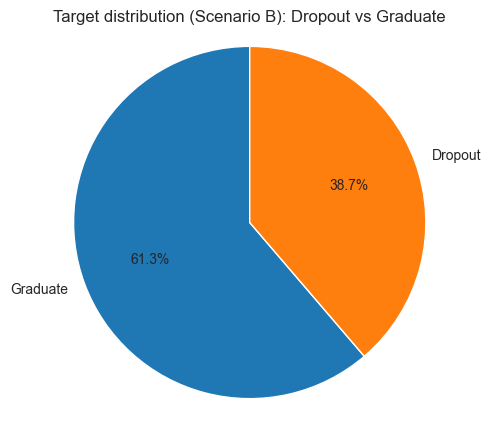

In [98]:
import matplotlib.pyplot as plt

counts = df["Target"].value_counts()

plt.figure(figsize=(5,5))
plt.pie(counts.values, labels=counts.index, autopct="%.1f%%", startangle=90)
plt.title("Target distribution (Scenario B): Dropout vs Graduate")
plt.axis("equal")  # עיגול מושלם
plt.show()

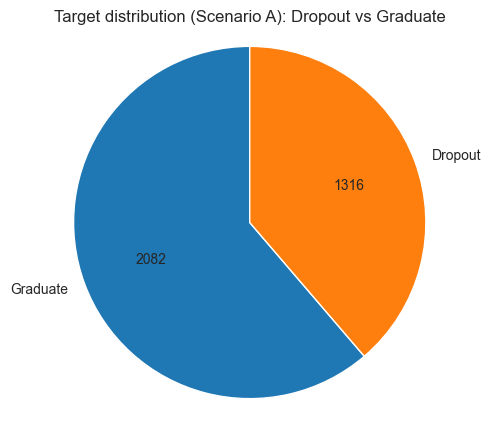

In [99]:
import matplotlib.pyplot as plt

counts = df["Target"].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    counts.values,
    labels=counts.index,
    startangle=90,
    autopct=lambda p: f"{int(round(p/100 * counts.sum()))}"
)
plt.title("Target distribution (Scenario A): Dropout vs Graduate")
plt.axis("equal")
plt.show()

In [100]:
numeric_cols = [
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
]

all_feature_cols = [c for c in df.columns if c != "Target"]

categorical_cols = [c for c in all_feature_cols if c not in numeric_cols]

In [101]:
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
for col in categorical_cols:
    df[col] = df[col].astype("category")

df = df.dropna(subset=numeric_cols)


In [102]:
df["y"] = (df["Target"] == "Dropout").astype(int)

X = df[all_feature_cols]
y = df["y"]


In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [104]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [105]:
log_reg = LogisticRegression(
    max_iter=2000,
    # class_weight="balanced"  # uncomment if dropout is very imbalanced
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_log = Pipeline([("prep", preprocess), ("model", log_reg)])
pipe_rf  = Pipeline([("prep", preprocess), ("model", rf)])
pipe_xgb = Pipeline([("prep", preprocess), ("model", xgb)])

In [106]:
pipe_log.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Logistic Regression results
Accuracy: 0.901
AUC: 0.938
Confusion Matrix:
 [[398  19]
 [ 48 215]]

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       417
           1       0.92      0.82      0.87       263

    accuracy                           0.90       680
   macro avg       0.91      0.89      0.89       680
weighted avg       0.90      0.90      0.90       680



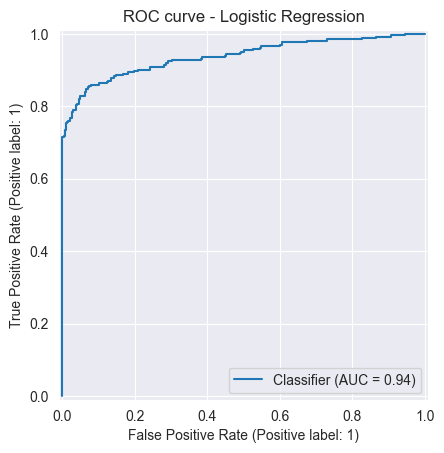


Random Forest results
Accuracy: 0.907
AUC: 0.949
Confusion Matrix:
 [[407  10]
 [ 53 210]]

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       417
           1       0.95      0.80      0.87       263

    accuracy                           0.91       680
   macro avg       0.92      0.89      0.90       680
weighted avg       0.91      0.91      0.91       680



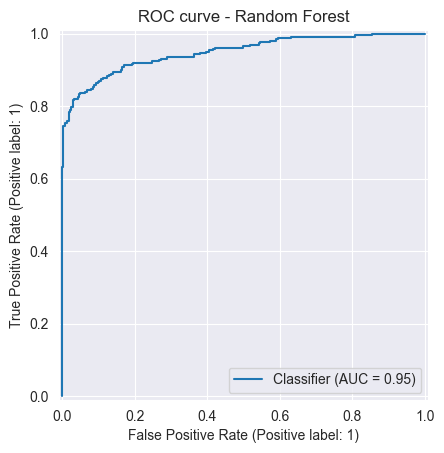


XGBoost results
Accuracy: 0.901
AUC: 0.945
Confusion Matrix:
 [[397  20]
 [ 47 216]]

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       417
           1       0.92      0.82      0.87       263

    accuracy                           0.90       680
   macro avg       0.90      0.89      0.89       680
weighted avg       0.90      0.90      0.90       680



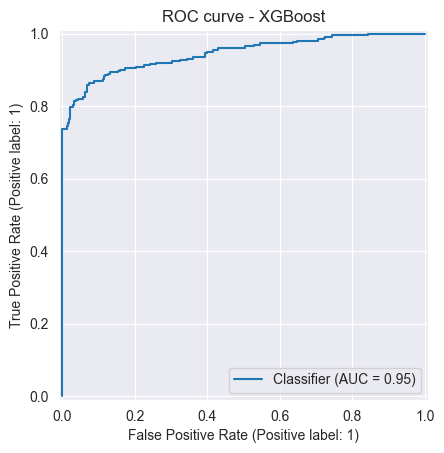

In [107]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def evaluate(model, name):
    print("\n" + "="*70)
    print(f"{name} results")
    print("="*70)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy:", round(acc, 3))
    print("AUC:", round(auc, 3))
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # optional: ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC curve - {name}")
    plt.show()

evaluate(pipe_log, "Logistic Regression")
evaluate(pipe_rf,  "Random Forest")
evaluate(pipe_xgb, "XGBoost")

### feature importance of the XGBoost model

In [108]:
xgb_model = pipe_xgb.named_steps["model"]

In [109]:
# Fit preprocessing on train data if not yet fitted
preprocess.fit(X_train)

ohe = preprocess.named_transformers_["cat"]
encoded_cat_names = list(ohe.get_feature_names_out(categorical_cols))

feature_names = numeric_cols + encoded_cat_names

In [110]:
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

In [111]:
importance_df = pd.DataFrame([
    (feature_names[int(k[1:])], v)
    for k, v in importance_dict.items()
], columns=["feature", "gain_importance"])

importance_df = importance_df.sort_values("gain_importance", ascending=False)
print(importance_df.head(20))

                                   feature  gain_importance
166  Curricular units 2nd sem (approved)_0        97.829231
73               Tuition fees up to date_0        31.857317
1         Curricular units 2nd sem (grade)        17.532057
169  Curricular units 2nd sem (approved)_3        15.997445
168  Curricular units 2nd sem (approved)_2        14.289412
167  Curricular units 2nd sem (approved)_1        13.424565
74               Tuition fees up to date_1        13.056455
172  Curricular units 2nd sem (approved)_6         6.676147
77                    Scholarship holder_0         6.047645
78                    Scholarship holder_1         5.957211
170  Curricular units 2nd sem (approved)_4         5.071136
149  Curricular units 2nd sem (enrolled)_8         4.842056
14                     Application mode_15         4.831326
27                                Course_7         4.800053
124  Curricular units 1st sem (approved)_1         4.736191
130  Curricular units 1st sem (approved)

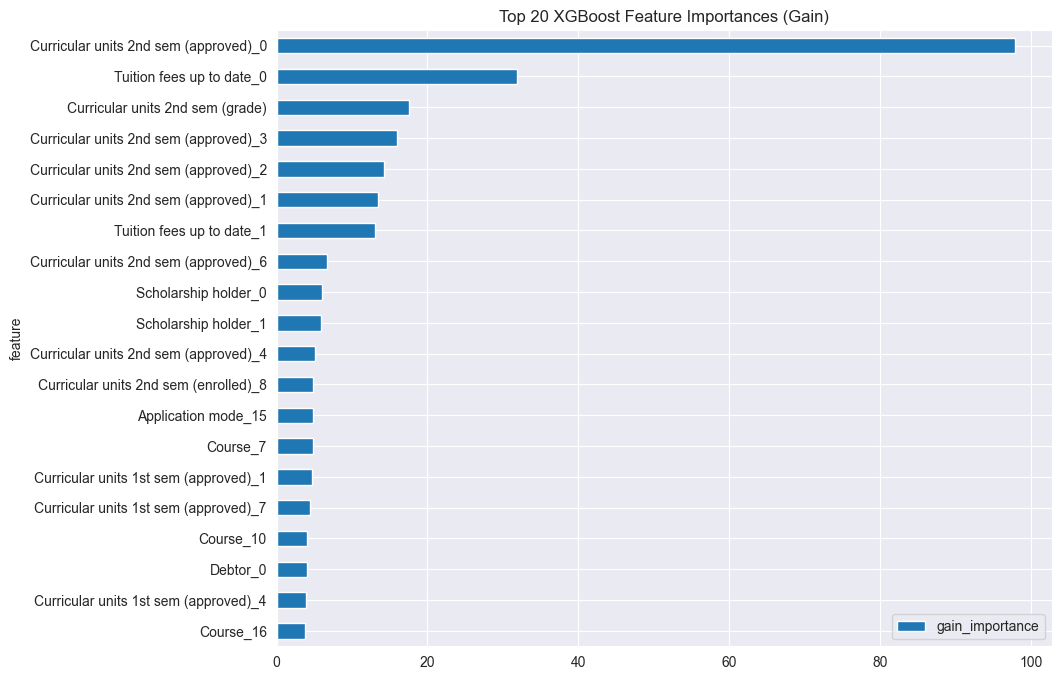

In [112]:
importance_df.head(20).plot(
    x='feature',
    y='gain_importance',
    kind='barh',
    figsize=(10,8)
)
plt.title("Top 20 XGBoost Feature Importances (Gain)")
plt.gca().invert_yaxis()
plt.show()

### Getting importance at the variable level (not each dummy)

In [113]:
# importance_df has columns: ["feature", "gain_importance"]

# base feature name = everything before the last underscore
importance_df["base_feature"] = importance_df["feature"].str.replace(r"_[^_]+$", "", regex=True)

# For numeric features (no underscore at the end) this leaves them as-is.

# Sum gain importance over all dummies of the same original feature
grouped_importance = (
    importance_df
    .groupby("base_feature")["gain_importance"]
    .sum()
    .sort_values(ascending=False)
)

print(grouped_importance.head(20))

base_feature
Curricular units 2nd sem (approved)       168.783442
Tuition fees up to date                    44.913772
Course                                     38.194543
Curricular units 1st sem (approved)        34.054681
Age at enrollment                          32.963151
Curricular units 1st sem (evaluations)     24.734205
Application mode                           22.527933
Curricular units 2nd sem (evaluations)     21.861443
Curricular units 2nd sem (enrolled)        21.118318
Curricular units 1st sem (enrolled)        20.032706
Curricular units 2nd sem (grade)           17.532057
Father's occupation                        16.418441
Mother's occupation                        14.467962
Scholarship holder                         12.004856
Curricular units 1st sem (credited)        10.921662
Curricular units 2nd sem (credited)        10.576864
Application order                          10.167705
Previous qualification                      8.727949
Father's qualification           

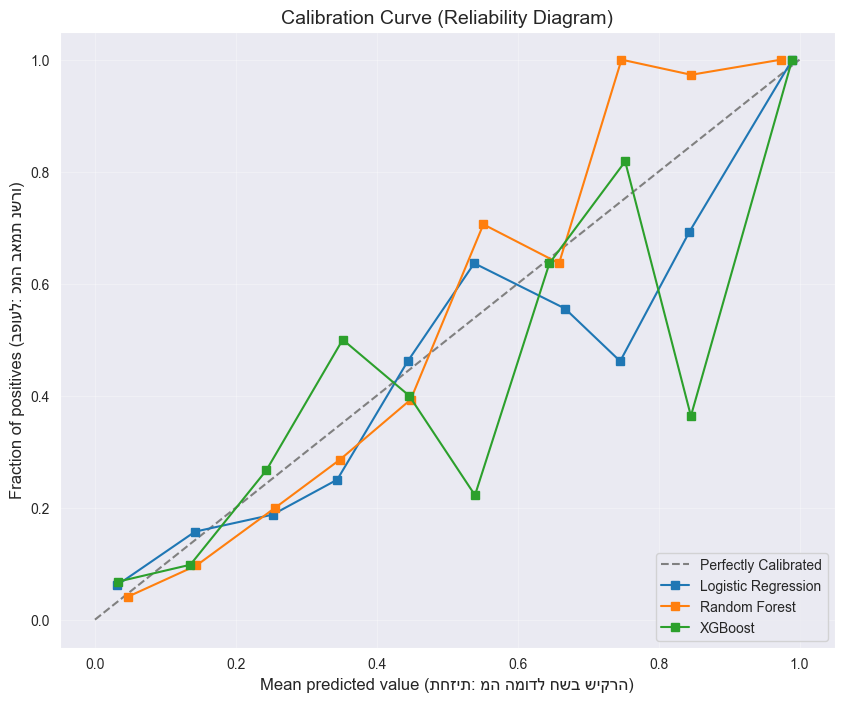

In [114]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# --- 1. הגדרת המודלים להשוואה ---
# וודא שהשמות כאן תואמים לשמות המשתנים במחברת שלך
models_to_plot = {
    "Logistic Regression": pipe_log,   # בדרך כלל הכי מכויל
    "Random Forest": pipe_rf,          # נוטה להיות בצורת S
    "XGBoost": pipe_xgb                # לרוב חזק מאוד
}

plt.figure(figsize=(10, 8))

# --- 2. ציור קו הייחוס (המודל המושלם) ---
# קו אלכסוני אפור: המטרה שלנו היא להיות כמה שיותר קרובים אליו
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

# --- 3. לולאה על כל המודלים וחישוב העקומה ---
for name, model in models_to_plot.items():
    # חישוב ההסתברויות (כמו שעשינו ב-AUC)
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(X_test)[:, 1]
    else:
        # למקרה שיש מודל בלי predict_proba (נדיר בשימוש שלנו)
        continue

    # הפונקציה שמחשבת את הכיול
    # n_bins=10 אומר שאנחנו מחלקים את הסטודנטים ל-10 קבוצות לפי רמת הסיכון
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    # הוספה לגרף
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

# --- 4. עיצוב הגרף ---
plt.ylabel("Fraction of positives (בפועל: כמה באמת נשרו)", fontsize=12)
plt.xlabel("Mean predicted value (תחזית: מה המודל חשב שיקרה)", fontsize=12)
plt.title("Calibration Curve (Reliability Diagram)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.show()

In [115]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# --- הגדרות ---
n_iterations = 1000  # כמה פעמים לדגום (סטנדרט מקובל)
confidence_level = 0.95 # רמת ביטחון (95%)
alpha = (1.0 - confidence_level) / 2.0 # (2.5% לכל צד)

# --- בחירת המודל לניתוח ---
# עדיף להשתמש במודל המכויל או ב-pipe_xgb/pipe_rf
current_model = pipe_xgb
# או: current_model = pipe_xgb

print(f"מבצע Bootstrapping (1000 חזרות) למודל: {current_model.steps[-1][1].__class__.__name__ if hasattr(current_model, 'steps') else 'CalibratedModel'}...")

# רשימות לשמירת התוצאות מכל הרצה
stats = {
    "AUC": [],
    "Precision (Dropout)": [],
    "Recall (Dropout)": [],
    "F1 Score": []
}

# --- חישוב תחזיות פעם אחת על כל הדאטה המקורי (לנוחות) ---
# הערה: בשיטה המחמירה ביותר היינו מריצים predict בתוך הלולאה,
# אבל כאן נדגום את התחזיות עצמן כדי לחסוך זמן חישוב, זה תקין סטטיסטית ל-Test Set.
all_y_true = y_test.values
all_y_pred = current_model.predict(X_test)
all_y_proba = current_model.predict_proba(X_test)[:, 1]

# --- לולאת ה-Bootstrap ---
for i in range(n_iterations):
    # 1. דגימה מחדש (Resampling)
    # אנו מגרילים אינדקסים ואז שולפים את הנתונים המתאימים
    indices = resample(range(len(all_y_true)), replace=True)

    y_true_boot = all_y_true[indices]
    y_pred_boot = all_y_pred[indices]
    y_proba_boot = all_y_proba[indices]

    # בדיקת קצה: לוודא שיש את שתי המחלקות (לפעמים בהגרלה יוצא רק 0 או רק 1)
    if len(np.unique(y_true_boot)) < 2:
        continue

    # 2. חישוב המדדים ושמירה
    stats["AUC"].append(roc_auc_score(y_true_boot, y_proba_boot))
    stats["Precision (Dropout)"].append(precision_score(y_true_boot, y_pred_boot, pos_label=1))
    stats["Recall (Dropout)"].append(recall_score(y_true_boot, y_pred_boot, pos_label=1))
    stats["F1 Score"].append(f1_score(y_true_boot, y_pred_boot, pos_label=1))

# --- הדפסת התוצאות ---
print(f"\n{'Metric':<20} | {'Mean':<8} | {'95% CI (Lower - Upper)':<25}")
print("-" * 60)

for metric_name, scores in stats.items():
    # המרת הרשימה למערך של numpy לחישובים
    scores = np.array(scores)

    # חישוב הממוצע והאחוזונים
    mean_score = np.mean(scores)
    lower = np.percentile(scores, alpha * 100)       # אחוזון 2.5
    upper = np.percentile(scores, (1.0 - alpha) * 100) # אחוזון 97.5

    print(f"{metric_name:<20} | {mean_score:.4f}   | [{lower:.4f} - {upper:.4f}]")

מבצע Bootstrapping (1000 חזרות) למודל: XGBClassifier...

Metric               | Mean     | 95% CI (Lower - Upper)   
------------------------------------------------------------
AUC                  | 0.9449   | [0.9264 - 0.9622]
Precision (Dropout)  | 0.9139   | [0.8756 - 0.9469]
Recall (Dropout)     | 0.8213   | [0.7710 - 0.8640]
F1 Score             | 0.8649   | [0.8307 - 0.8952]


In [117]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# --- הגדרות ---
n_iterations = 1000  # כמה פעמים לדגום (סטנדרט מקובל)
confidence_level = 0.95 # רמת ביטחון (95%)
alpha = (1.0 - confidence_level) / 2.0 # (2.5% לכל צד)

# --- בחירת המודל לניתוח ---
# עדיף להשתמש במודל המכויל או ב-pipe_xgb/pipe_rf
current_model = pipe_log
# או: current_model = pipe_xgb

print(f"מבצע Bootstrapping (1000 חזרות) למודל: {current_model.steps[-1][1].__class__.__name__ if hasattr(current_model, 'steps') else 'CalibratedModel'}...")

# רשימות לשמירת התוצאות מכל הרצה
stats = {
    "AUC": [],
    "Precision (Dropout)": [],
    "Recall (Dropout)": [],
    "F1 Score": []
}

# --- חישוב תחזיות פעם אחת על כל הדאטה המקורי (לנוחות) ---
# הערה: בשיטה המחמירה ביותר היינו מריצים predict בתוך הלולאה,
# אבל כאן נדגום את התחזיות עצמן כדי לחסוך זמן חישוב, זה תקין סטטיסטית ל-Test Set.
all_y_true = y_test.values
all_y_pred = current_model.predict(X_test)
all_y_proba = current_model.predict_proba(X_test)[:, 1]

# --- לולאת ה-Bootstrap ---
for i in range(n_iterations):
    # 1. דגימה מחדש (Resampling)
    # אנו מגרילים אינדקסים ואז שולפים את הנתונים המתאימים
    indices = resample(range(len(all_y_true)), replace=True)

    y_true_boot = all_y_true[indices]
    y_pred_boot = all_y_pred[indices]
    y_proba_boot = all_y_proba[indices]

    # בדיקת קצה: לוודא שיש את שתי המחלקות (לפעמים בהגרלה יוצא רק 0 או רק 1)
    if len(np.unique(y_true_boot)) < 2:
        continue

    # 2. חישוב המדדים ושמירה
    stats["AUC"].append(roc_auc_score(y_true_boot, y_proba_boot))
    stats["Precision (Dropout)"].append(precision_score(y_true_boot, y_pred_boot, pos_label=1))
    stats["Recall (Dropout)"].append(recall_score(y_true_boot, y_pred_boot, pos_label=1))
    stats["F1 Score"].append(f1_score(y_true_boot, y_pred_boot, pos_label=1))

# --- הדפסת התוצאות ---
print(f"\n{'Metric':<20} | {'Mean':<8} | {'95% CI (Lower - Upper)':<25}")
print("-" * 60)

for metric_name, scores in stats.items():
    # המרת הרשימה למערך של numpy לחישובים
    scores = np.array(scores)

    # חישוב הממוצע והאחוזונים
    mean_score = np.mean(scores)
    lower = np.percentile(scores, alpha * 100)       # אחוזון 2.5
    upper = np.percentile(scores, (1.0 - alpha) * 100) # אחוזון 97.5

    print(f"{metric_name:<20} | {mean_score:.4f}   | [{lower:.4f} - {upper:.4f}]")

מבצע Bootstrapping (1000 חזרות) למודל: LogisticRegression...

Metric               | Mean     | 95% CI (Lower - Upper)   
------------------------------------------------------------
AUC                  | 0.9376   | [0.9157 - 0.9580]
Precision (Dropout)  | 0.9197   | [0.8856 - 0.9532]
Recall (Dropout)     | 0.8177   | [0.7698 - 0.8643]
F1 Score             | 0.8655   | [0.8330 - 0.8957]


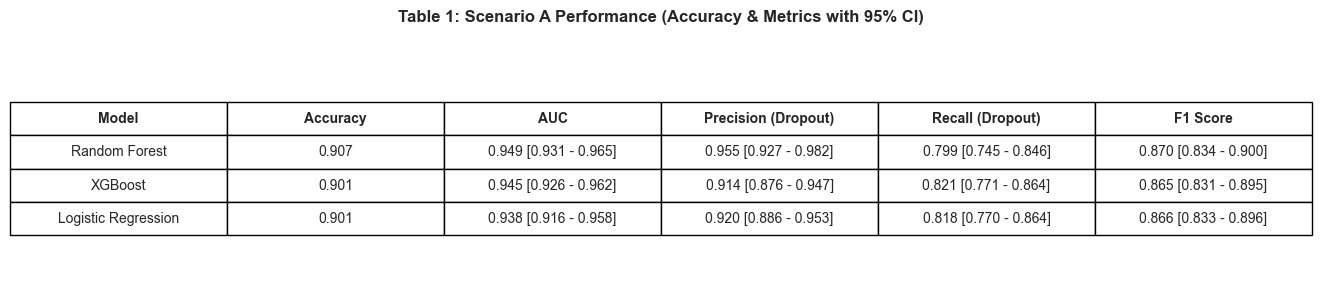

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. הזנת הנתונים
# Accuracy: ללא רווח סמך (כפי שביקשת)
# שאר המדדים: עם רווח סמך (מהנתונים ששלחת קודם)
data = {
    "Model": ["Random Forest", "XGBoost", "Logistic Regression"],

    "Accuracy": ["0.907", "0.901", "0.901"],  # תיקנתי את ה-0.091 ל-0.901

    "AUC": [
        "0.949 [0.931 - 0.965]",
        "0.945 [0.926 - 0.962]",
        "0.938 [0.916 - 0.958]"
    ],

    "Precision (Dropout)": [
        "0.955 [0.927 - 0.982]",
        "0.914 [0.876 - 0.947]",
        "0.920 [0.886 - 0.953]"
    ],

    "Recall (Dropout)": [
        "0.799 [0.745 - 0.846]",
        "0.821 [0.771 - 0.864]",
        "0.818 [0.770 - 0.864]"
    ],

    "F1 Score": [
        "0.870 [0.834 - 0.900]",
        "0.865 [0.831 - 0.895]",
        "0.866 [0.833 - 0.896]"
    ]
}

# 2. יצירת DataFrame
df_table1 = pd.DataFrame(data)

# 3. יצירת הטבלה הגרפית
fig, ax = plt.subplots(figsize=(14, 3)) # הרחבתי עוד קצת כי נוספה עמודה
ax.axis('tight')
ax.axis('off')

# יצירת אובייקט הטבלה
table = ax.table(cellText=df_table1.values,
                 colLabels=df_table1.columns,
                 cellLoc='center',
                 loc='center')

# 4. עיצוב
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2) # מרווח אנכי נוח לקריאה

# הדגשת שורת הכותרת בבולד
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

# 5. כותרת
plt.title("Table 1: Scenario A Performance (Accuracy & Metrics with 95% CI)", y=1.1, fontweight='bold')

# שמירה לקובץ
plt.savefig("table1_scenario_a_final.png", bbox_inches='tight', dpi=300)
plt.show()